In [1]:
import tensorflow as tf
from tensorflow import optimizers
from tensorflow import experimental
import keras
import time
import os
import imageio
from PIL import Image
from IPython import display
from keras import layers
from tensorflow.python.client import device_lib
from keras import utils
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import numpy
from tensorflow.python.framework.ops import disable_eager_execution

In [25]:
class Denoise(tf.keras.models.Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(32, 32, 3)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(16, kernel_size=3, strides=1, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

(x_train, _), (x_test, _) = tf.keras.datasets.cifar100.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


In [24]:
noise_factor = 0.2
@tf.function
def fun(x_train,x_test,noise_factor = 0.1):
    x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
    x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)
    x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
    x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)
    x_train_noisy=tf.convert_to_tensor(x_train_noisy,numpy.float32)
    x_test_noisy=tf.convert_to_tensor(x_test_noisy,numpy.float32)
    return (x_train_noisy,x_test_noisy)
(x_train_noisy,x_test_noisy)=fun(x_train,x_test,noise_factor = 0.05)


In [26]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                validation_data=(x_test_noisy, x_test),steps_per_epoch=int( numpy.ceil(x_train.shape[0] / 32)))


Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0094 - val_loss: 0.0052
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0041 - val_loss: 0.0033
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 7/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 8/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/10
1563/1563 [==============================] - 10s 6ms/step - loss

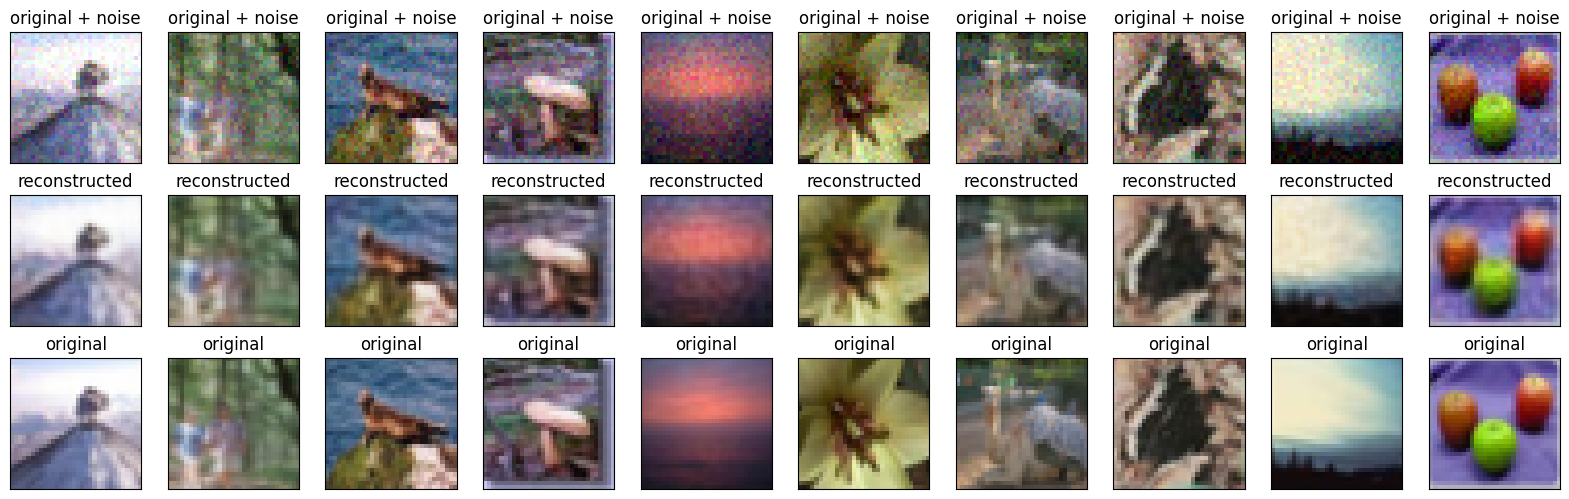

In [27]:

encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original + noise
    ax = plt.subplot(3, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(3, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    cx=plt.subplot(3,n,i+2*n+1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test[i]))
    plt.gray()
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)


plt.show()

